# Colin Lefter

## Research question/interests

**What equity data is the most deterministic of the price of an equity, and of this data, which is the most relevant for a growth portfolio investment strategy such that we can compute an optimized portfolio of equities while using user input to drive our optimization algorithm?**

My research objective is to develop a scalable asset allocation and construction algorithm that implements an objected-oriented design approach. This objective is an outcome of determining what equity data is the most deterministic of the price of an equity, which will be the focus for the majority of the project/

I intend to develop algorithms for constructing multiple linear regressions and Fourier Franforms, among others, that I will then use to construct interactive and statistical models with Plotly and Seaborn. As such, I have a strong interest in the system design of our software and in developing helper functions that can assist all of us with processing data more efficiently. I am also looking forward to using Facebook Prophet[^1] to construct a time series forecast of a sample portfolio recommendation from our software, which can be included in our Tableau Dashboard.

### Analysis Plan
Our objective function is one that takes in a selection of columns from our data sets to then search for the top n companies that satisfy a criteria for having the highest probability of producing an optimal return on investment. These inputs themselves refer to sub-objective functions that take as input user-defined parameters and thresholds that set the criteria for favourable performance attributes. To rank the companies from our data set, and ultimately determine what portion of capital to assign to each equity, I propose a data normalization algorithm that normalizes the data that comprises the favourable subset from each column of our data set. We interpret these normalized values as probabilities of equity selection and ultimately average the score of each company across all columns to then multiply the final score percentage of each company with the total capital specified by the user. In a broad sense, our software is composed of four general classes that include "Data", "Quantitative Analysis", "Data Visualization" and "Portfolio Construction". We inherit the properties from each of these classes to build a functional data analysis chain.

Our data visualization will be concerned with analyzing the influence of certain financial variables, such as Price-to-Earnings, on the price of each equity from a sample of 500 equities (from the S&P 500 index). Such analysis would begin with a statistical summary that will constitute exploratory data analysis, followed by our application of analysis algorithms that we design. The construction of a portfolio is a bonus of our project and will be made possible by the analysis algorithms we have constructed.

**Important Note**
A component of the analysis will involve the comparison of different values of financial variables with the corresponding price of each equity. This constitutes inferential analysis as we are attempting to identify a correlation on the basis of picking stocks based on expected performance. Therefore, this will require us to use past financial data and compare this data with the current price of each equity. As a result, we can only use the 3-month performance data (i.e. 3-month change in share price data) for this comparison as otherwise we would be using future data to predict past performance, which would be invalid.

#### User-defined parameters
Some initial ideas for these parameters include:
- (float) Initial capital
- (float) Additional capital per day, week or month
- (int) Intended holding period (in days)
- (boolean) Importance of dividends (validated based on capital invested)
- (String) Preferred industries (choose from a list, or select all)
- (int) Volatility tolerance (from 0 to 1, 1 indicating that volatility is not important)
- (String) Preferred companies (as a list)[^2]
- (int) Preferred degree of portfolio diversification (from 0 to 1, 1 indicating complete diversification)
- (String) Preferred investment strategy (choose from "Growth", "Value", "GARP")

### Algorithm Plan

####  Tier 1: Threshold-based screening algorithms
- The current plan is to use these algorithms to screen the financial documents from each company by setting a minimum threshold for each financial ratio. This class of algorithms will need to conduct such screening per industry as industry financial ratios are dinstinct from one another.
- A global screening algorithm that selects companies which show favourable performance across all ratios can also be used after each ratio has been individually tested.

#### Tier 2: Regression models
- As of now, the intent is to develop a multiple linear regression model that will attempt to determine a relationship between the yearly and quarterly performance of each company in relation to several columns of data that act as predictors. This can essentially implement the results from the threshold-based screening algorithms to only conduct this analysis on the pre-screened companies.

#### Tier 3: Statistical modelling algorithms
- Tier 3 denotes a class of broadly experimental statistical modelling algorithms that are applied on a pre-final portfolio to add additional points to companies that perform exceptionally well compared to others in the portfolio. For now, these algorithms constitute signal processing algorithms such as a Fourier Transform algorithm that attempts to identify peaks in numerical values that would otherwise not be apparent when examined in isolation and without further processing. Therefore, these algorithms will be used to fine-tune the capital allocation percentages for each company in the pre-final portfolio.

#### Columns of relevance
Data set 1: Overview
- Price
- MKT Cap
- P/E
- EPS
- Sector

Data set 2: Performance
- 1M change (1 month change)
- 3-Month performance
- 6-month perfromance
- YTD performance
- Yearly performance
- Volatility

Data set 3: Valuation
- Price / revenue
- Enterprise value

Data set 4: Dividends
- Dividend yield FWD
- Dividends per share (FY)

Data set 5: Margins
- Gross profit margin
- Operating margin
- Net profit margin

Data set 6: Income Statement
- Gross profit
- Income
- Net cash flow

Data set 7: Balance Sheet
- Current ratio
- Debt/equity
- Quick ratio

The total number of columns would be 24 in this case.

[^1]: This would mean that a few time series data sets would need to be downloaded from TradingView at the end of the project to test the demo porfolio.

[^2]: A helper function can be developed for this, where the user can just type out the name of the company and the ticker is identifed.

In [27]:
import pandas as pd
import plotly as plt
import seaborn as sns
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from IPython.display import display, HTML, Markdown, Latex
from tqdm import tqdm, trange
from typing import *
from dataclasses import dataclass
from scipy import stats
import plotly.io as pio
import sys
sys.path.append('..')
from analysis.code import project_functions1 as pf
sns.set_theme(style="darkgrid")
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

#pio.renderers.default = "svg"

In [28]:
@dataclass
class ValueRange:
    min: float
    max: float
    
    def validate(self, x):
        """Checks if inputs to variables that must lie within a specific range are valid
        
        :x: the value that must be checked as satisfying the specified range
        :raises ValueError: if the value does not lie within the specified range
        """
        if not (self.min <= x <= self.max):
            raise ValueError(f'{x} must be between 0 and 1 (including).')

# Data Loading

In [29]:
equities = pf.EquityData()
overview_df = equities.load_and_process("overview", exclude_columns=['Change %', 'Change', 'Technical Rating', 'Volume', 'Volume*Price'])
income_statement_df = equities.load_and_process("income_statement")
balance_sheet_df = equities.load_and_process("balance_sheet")
dividends_df = equities.load_and_process("dividends", exclude_columns=['Price'])
margins_df = equities.load_and_process("margins")
performance_df = equities.load_and_process("performance", exclude_columns=['Change 1m, %', 'Change 5m, %', 'Change 15m, %', 'Change 1h, %', 'Change 4h, %', 'Change 1W, %', 'Change 1M, %', 'Change %'])
valuation_df = equities.load_and_process("valuation", exclude_columns=['Price', 'Market Capitalization', 'Price to Earnings Ratio (TTM)', 'Basic EPS (TTM)', 'EPS Diluted (FY)'])

### Analysis-Specific Data Wrangling

In [30]:
dfs = [
    overview_df,
    income_statement_df,
    balance_sheet_df,
    dividends_df,
    margins_df,
    performance_df,
    valuation_df
    ]

dfs_names = [
    "Overview Data",
    "Balance Sheet Data",
    "Dividends Data",
    "Income Statement Data",
    "Margins Data",
    "Performance Data",
    "Valuation Data"
    ]

overview_df['3-Month Performance'] = performance_df['3-Month Performance']
income_statement_df['3-Month Performance'] = performance_df['3-Month Performance']
balance_sheet_df['3-Month Performance'] = performance_df['3-Month Performance']
dividends_df['3-Month Performance'] = performance_df['3-Month Performance']
margins_df['3-Month Performance'] = performance_df['3-Month Performance']
valuation_df['3-Month Performance'] = performance_df['3-Month Performance']

mega_df = pd.concat(dfs, axis=1)
mega_df = mega_df.loc[:,~mega_df.columns.duplicated()].copy()
mega_df = mega_df.dropna()
mega_df_no_strings = mega_df.select_dtypes(exclude='object')

mega_df['6-Month Performance'] = performance_df['6-Month Performance']
mega_df['YTD Performance'] = performance_df['YTD Performance']
mega_df['Yearly Performance'] = performance_df['Yearly Performance']

# Functional Classes

In [31]:
class QuantitativeAnalysis:
    def __init__(self, number_of_companies: int=500, initial_capital: float=100000.00, capital_per_period: float=100.00, period: int=7, dividends_importance: bool=False, preferred_industries: list=["Technology Services, Electronic Technology"],
                volatility_tolerance: Annotated[float, ValueRange(0.0, 1.0)]=0.7, preferred_companies: list=["Apple, Google, Microsoft, Amazon"], diversification: Annotated[float, ValueRange(0.0, 1.0)]=0.4, investment_strategy: str="Growth"):
        """Includes several analysis functions that process select data across all data sets

        :number_of_companies: the number of companies included in the sample, with the default being those from the S&P500 Index\n
        :initial_capital: the initial amount of cash to be invested by the client, in USD\n
        :capital_per_period: the amount of cash to be invested by the client at a fixed rate in addition to the initial capital invested, in USD\n
        :period: the frequency (in days) at which additional cash is invested, if desired\n
        :dividends_importance: specifies whether dividends are important to the client, dictating whether analysis algorithms should place greater importance on dividends\n
        :preferred_industries: specifies a list of industries that the analysis algorithms should prioritize when constructing the investment portfolio\n
        :volatility_tolerance: accepts a range of values from 0 to 1, with 1 implying maximum volatility tolerance (i.e. the client is willing to lose 100% of their investment to take on more risk)\n
        :preferred_companies: specifies a list of companies that the analysis algorithms will accomodate in the final portfolio irrespective of their score\n
        :diversification: accepts a range of values from 0 to 1, with 1 implying maximum diversification (i.e. funds will be distributed evenly across all industries and equally among all companies)\n
        :investment_strategy: specifies the investment strategy that will guide the output of the analysis algorithms, in which this analysis notebook strictly focuses on growth investing\n
        :raises: ValueError if an input parameter does not satisfy its accepted range
        """
        
        self.number_of_companies = number_of_companies
        self.initial_capital = initial_capital
        self.capital_per_period = capital_per_period
        self.period = period
        self.dividends_importance = dividends_importance
        self.preferred_industries = preferred_industries
        self.volatility_tolerance = volatility_tolerance
        self.preferred_companies = preferred_companies
        self.diversification = diversification
        self.preferred_companies = preferred_industries
        self.investment_strategy = investment_strategy
        
    def lin_reg_coef_determination(self, df: pd.DataFrame, X: str, y: str='3-Month Performance', filter_outliers: bool=True):
        if filter_outliers:
            df = self.outlier_filtered_df(df, col=y)
        
        X = df[X]
        y = df[y]
        
        y = y.dropna()
        X = X.dropna()
        
        if len(X) > len(y):
            X = X[:len(y)]
        else:
            y = y[:len(X)]
        
        self.X = np.array(X).reshape(-1, 1)
        self.y = np.array(y).reshape(-1, 1)
        
        model = LinearRegression()
        model.fit(self.X, self.y)
         
        return model.score(self.X, self.y)

    def get_lin_reg_coefs(self, df: pd.DataFrame, x_values: list(), y_value: str='3-Month Performance') -> pd.DataFrame:
        """Returns a Pandas DataFrame with the coefficients of determination for each y-on-x regression
        Example: 3-Month Performance against Price to Earnings Ratio (TTM)
        
        :df: the data frame that contains the columns to process\n
        :x_values: a list of strings of the names of each column to process\n
        :y_value: a common y-value to map each x value against in the regression analysis\n
        :returns: A Pandas DataFrame with the coefficients of determination for each y-on-x regression\n
        
        """
        self.coef_dict = dict.fromkeys(x_values, 0) # initialize a dict with all the columns assigned to a value of 0
        
        for predictor in tqdm(x_values, desc="Constructing linear regression models", total=len(x_values)):
            self.coef_dict[predictor] = self.lin_reg_coef_determination(df, X=predictor, y=y_value)
        
        self.processed_df = pd.DataFrame(list(zip(self.coef_dict.keys(), self.coef_dict.values())), columns=[f'Equity Data Against {y_value}', 'Coefficient of Determination'])
        
        return self.processed_df
        
    def fourier_transform(self):
        pass
    
    def rank(self, df: pd.DataFrame, col: str, normalize_only: bool=True, threshold: float=1.5,
             below_threshold: bool=True, filter_outliers: bool=True, normalize_after: bool=False,
             lower_quantile: float=0.05, upper_quantile: float=0.95):
        """The scoring algorithm for determining the weight of each equity in the construction of the portfolio for this specific column examined.
        Features a custom outlier-filtering algorithm that is robust to outliers in the data set while still returning normalized values.
        
        :df: The original dataframe\n
        :col: The name of the column being extracted from the dataframe provided\n
        :normalize_only: if True, does not apply a threshold to the screening algorithm, and only normalizes values with a minmax scaler\n
        :threshold: the minimum value that equities must have for that column in order to be considered for further analysis\n
        :below_threshold: if True, removes equities that are below the threshold for that column\n
        :filter_outliers: if True, does not consider equities in the data normalization algorithm, but assigns a min or max value to all outliers depending on the below_threshold parameter\n
        :normalize_after: if True, normalizes the data only after the threshold filter has been applied\n
        :lower_quantile: specifies the lower quantile of the distribution when filtering outliers\n
        :upper_quantile: specifies the upper quantile of the distribution when filtering outliers\n
        """
        
        #NOTE: should make an option for no threshold
        self.x = df[col]
        new_col = col + " Score"
        
        # normalization can be done either before or after equities have been filtered by the threshold
        # the difference is that by filtering initially, the min and max values of that smaller set will become 0 and 1 respectively
        df[new_col] = np.NaN # initialize the score column with only NaN values
        
        def outlier_filter(self):
            """Nested helper function to filter outliers"""
            upper_fence = self.x.quantile(upper_quantile)
            lower_fence = self.x.quantile(lower_quantile)
            
            if below_threshold:
                df.loc[self.x > upper_fence, new_col] = 1 # outliers still need to be included in the data (max score assigned)
                df.loc[self.x < lower_fence, new_col] = 0 # lowest score assigned
            else:
                # inverse of the above
                df.loc[self.x > upper_fence, new_col] = 0
                df.loc[self.x < lower_fence, new_col] = 1

            # now only take the rows that are not outliers into the minmax scaler
            self.x = self.x[(self.x <= upper_fence) & (self.x >= lower_fence)]
            
            if normalize_only:
                normalize_after = False
                
            if normalize_after:
                if below_threshold:
                    # since we are only taking valid values, we consider the inverse of the values that are below the threshold to be valid values
                    self.x = self.x[self.x >= threshold]
                else:
                    self.x = self.x[self.x <= threshold]
        
        if filter_outliers:
            outlier_filter(self)
        
        self.y = np.array(self.x).reshape(-1, 1)
        self.y = preprocessing.MinMaxScaler().fit_transform(self.y)
 
        for col_idx, array_idx in zip(self.x.index, range(len(self.y))):
            df.at[col_idx, new_col] = self.y[array_idx]
        
        # if we are giving the minimum score to values below the threshold, assign 0 to those values
        if not normalize_only:
            if below_threshold:
                df.loc[df[col] <= threshold, new_col] = 0
            else:
                df.loc[df[col] >= threshold, new_col] = 0
    
    def outlier_filtered_df(self, df: pd.DataFrame, col: list(), lower_quantile: float=0.05, upper_quantile: float=0.95):
        upper_fence = df[col].quantile(upper_quantile)
        lower_fence = df[col].quantile(lower_quantile)

        df = df[(df[col] <= upper_fence) & (df[col] >= lower_fence)]
        
        return df

In [32]:
class DataVisualization(QuantitativeAnalysis):
    def __init__(self):
        QuantitativeAnalysis.__init__(self)

    def score_density_plot(self, df: pd.DataFrame, data_name: str):
        """Constructs an interactive compound density plot based on a histogram of the data provided, plotting a density curve with clusters of data points below
        
        :df: a Pandas DataFrame of equity data
        :data_name: the name of the type of data that has been input into the plot
        :returns: a density plot
        """
        df = df.select_dtypes(exclude='object')[:self.number_of_companies]
        self.n = len(df)
        
        for column in df.columns:
            self.rank(df, col=column, upper_quantile=0.99, lower_quantile=0.01)
            
        self.score_data_length = len(df.axes[1])
        self.input_df = df.T[int(self.score_data_length/2 + 1):].T
        self.hist_data = [self.input_df[x] for x in self.input_df.columns]
        
        self.group_labels = [x for x in self.input_df.columns]
        self.colors = ['#333F44', '#37AA9C', '#94F3E4']

        self.fig = ff.create_distplot(self.hist_data, self.group_labels, show_hist=False, colors=self.colors)
        self.fig.update_layout(title_text=f'Distribution for Normalized {data_name} of {self.n} Companies in the S&P500', template='plotly_dark')
        
        self.fig.update_xaxes(title="Score (0 = low, 1 = high)")
        self.fig.update_yaxes(title="Count")
        
        return self.fig

    def heatmap_plot(self, df: pd.DataFrame, data_name: str, number_of_companies: int):
        """Constructs an interactive heatmap plot of equity data against each company (ticker)
        
        :df: a Pandas DataFrame of equity data
        :data_name: the name of the type of data that has been input into the plot
        :returns: a heatmap plot
        """
        df = df[:number_of_companies]
        self.z = []
        self.tickers = df['Ticker']
        df.index = df['Ticker']
        df = df.select_dtypes(exclude='object')
        for column in df.columns:
            self.rank(df, col=column)

        self.score_data_length = len(df.axes[1])
        self.input_df = df.T[int(self.score_data_length/2 + 1):].T
        for column in self.input_df.columns:
            self.z.append(self.input_df[column].round(3))
        
        # add text_auto=True as a parameter back to this function once latest Plotly update is installed
        self.title = f'Heat Map of Normalized {data_name} for the Top {number_of_companies} Companies by Market Capitalization in the S&P500 Index'
        
        fig = px.imshow(
            self.z, text_auto=True, template='plotly_dark', title=self.title, x=[x for x in self.tickers], y=[x for x in df.columns[int(self.score_data_length/2 + 1):]]
                )
        
        return fig

    def scatter_3d(self, df: pd.DataFrame, x: str, y: str, z: str):
        """Constructs a 3D interactive plot of equity data on 3 axes
        :df: a Pandas DataFrame of equity data
        :x: the name of the column data to be plotted on the x-axis, as a string
        :y: the name of the column data to be plotted on the y-axis, as a string
        :z: the name of the column data to be plotted on the z-axis, as a string
        :returns: a 3D scatter plot
        """
        df.index = df['Ticker']
        df = df.select_dtypes(exclude='object')
        
        for column in df.columns:
            self.rank(df, col=column)
            
        fig = px.scatter_3d(df, x=x, y=y, z=z,
                    title='3D Scatter Plot of Normalized Equity Data',
                    template='plotly_dark',
                    size_max=18,
                    color='3-Month Performance Score',
                    opacity=0.7)

        return fig

In [33]:
class PortfolioConstruction(DataVisualization):
    def __init__(self):
        DataVisualization.__init__(self)
    
    def asset_allocation(self):
        pass
    
    def construct_portfolio(self):
        pass

# Experimental Feature Development Zone

In [34]:
quant = QuantitativeAnalysis()
viz = DataVisualization()

/var/folders/ky/9rryppz96_n8vrbvm_pwmh640000gn/T/ipykernel_76463/2936197837.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<AxesSubplot:>

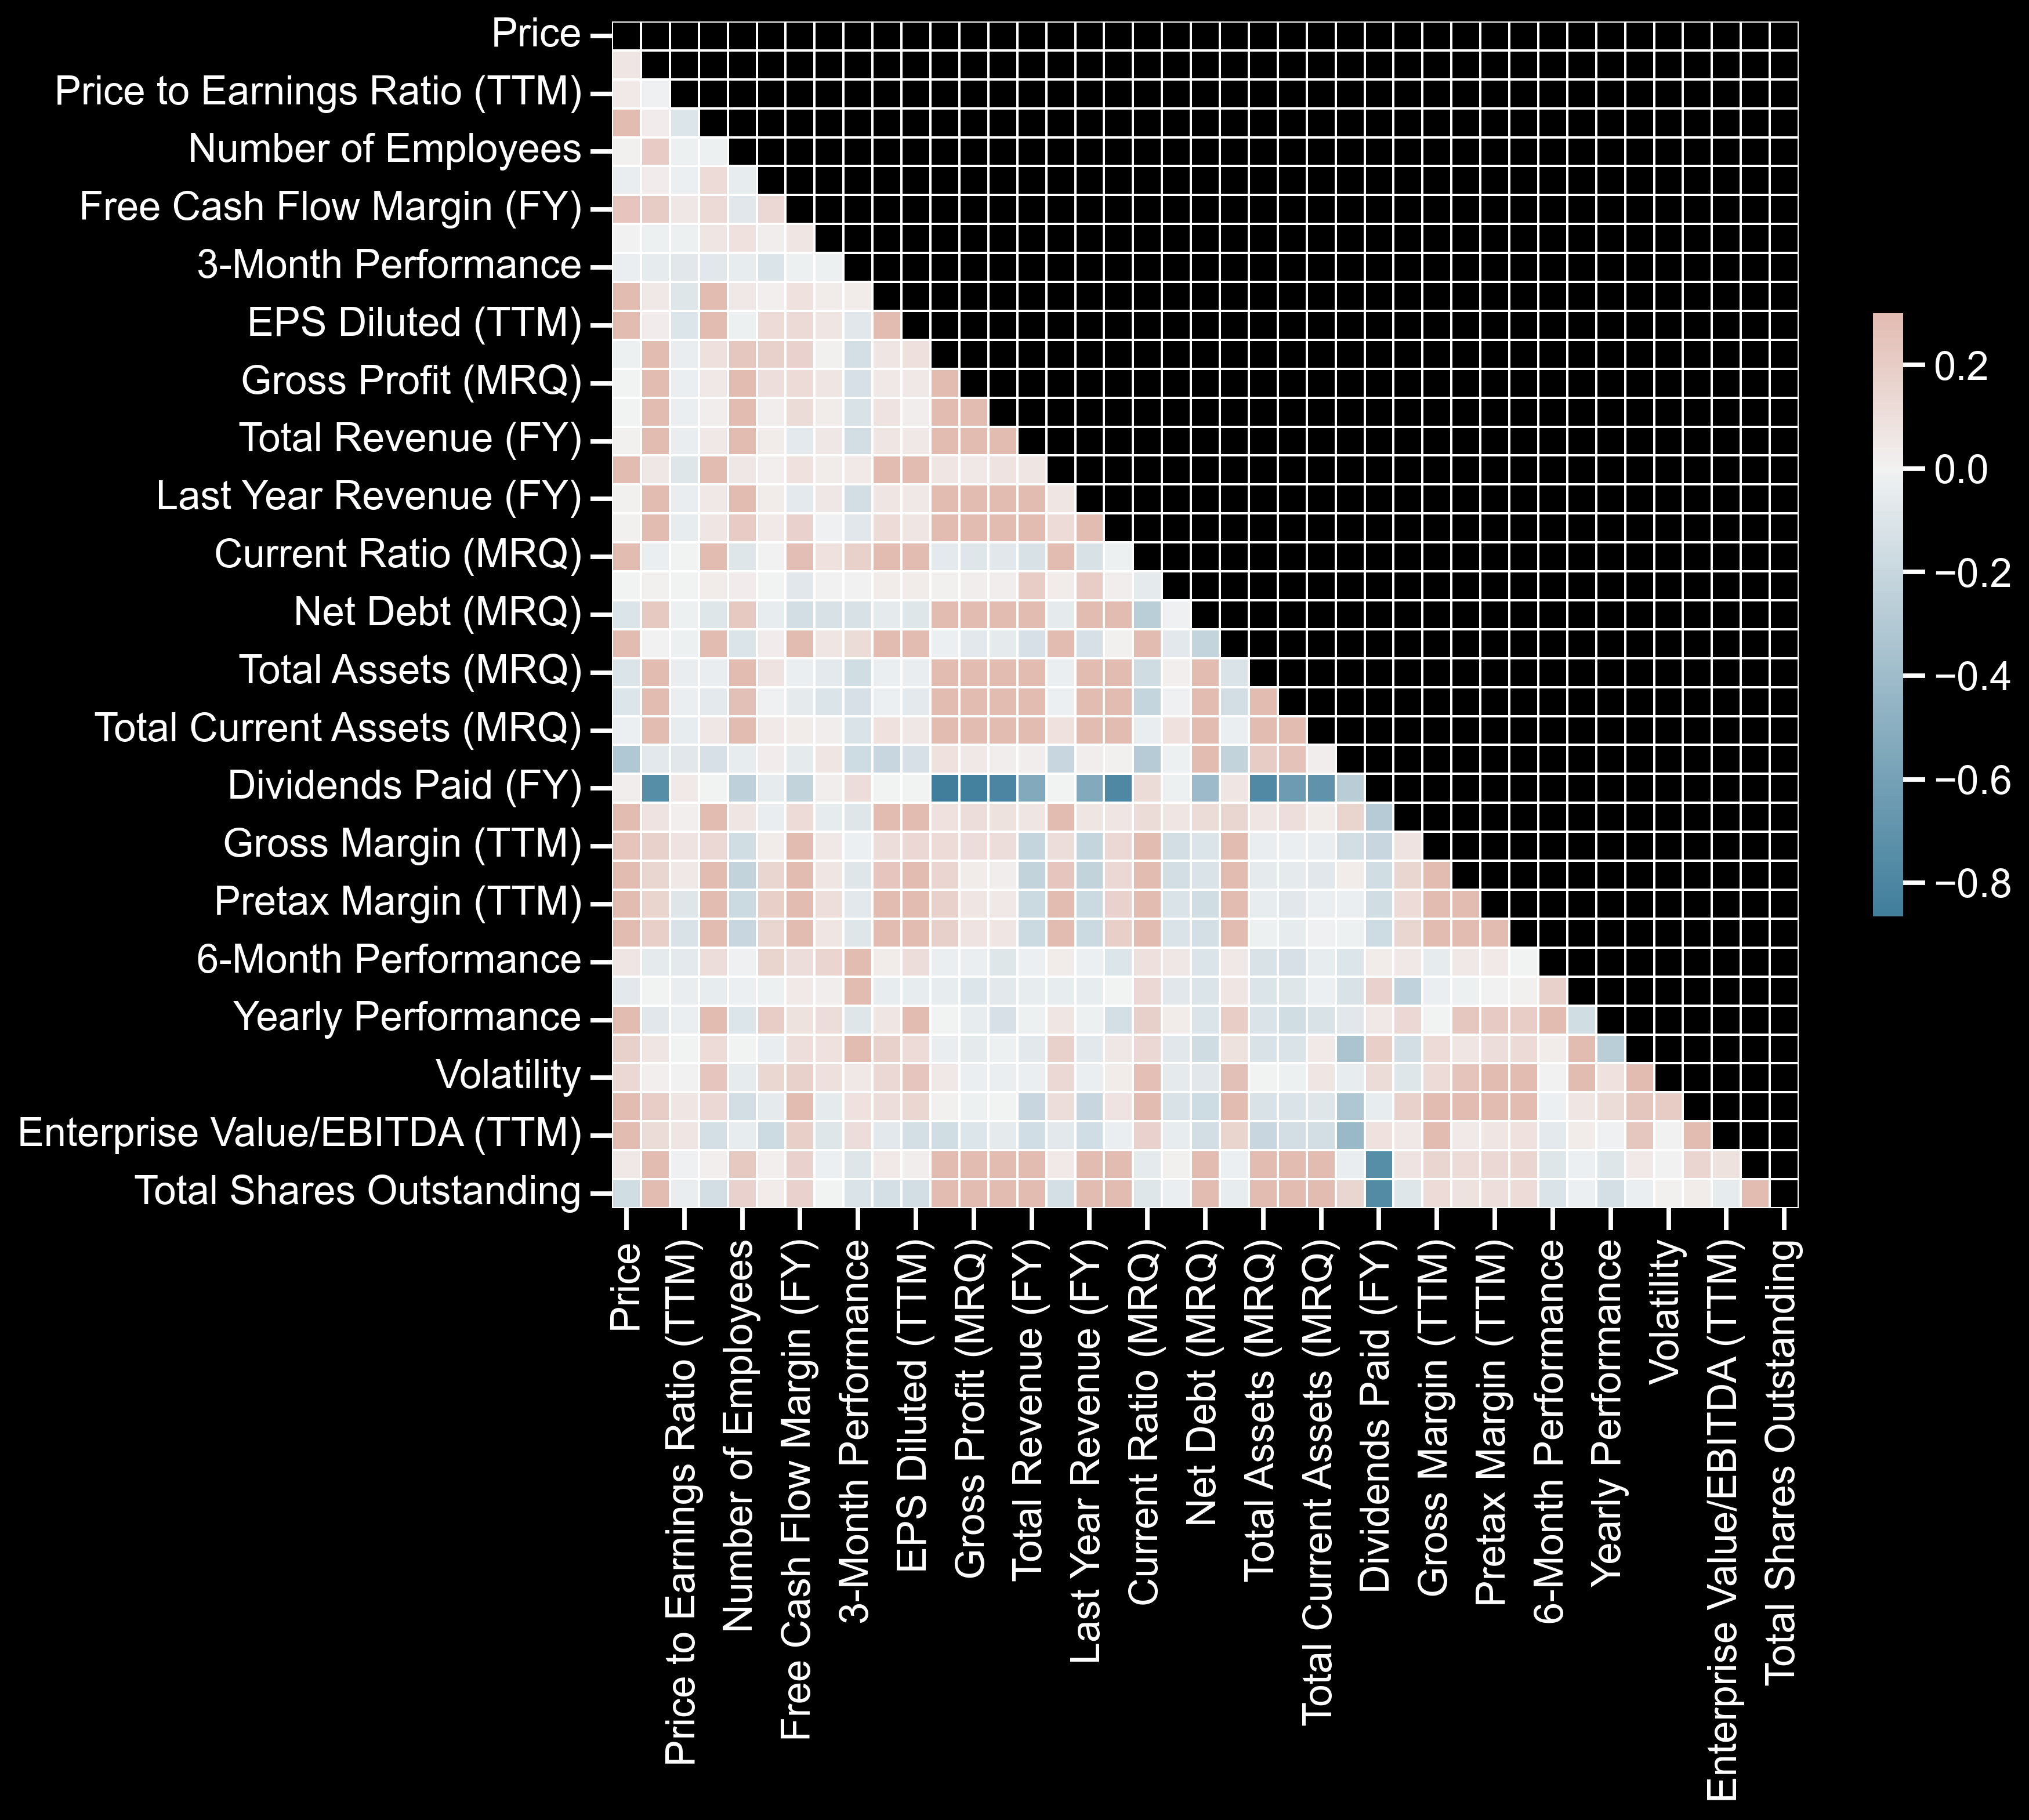

In [35]:
# Compute the correlation matrix
corr = mega_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#mega_df

In [36]:
config = {
  'toImageButtonOptions': {
    'format': 'png',
    'filename': 'custom_image',
    'height': 800,
    'width': 2000,
    'scale': 2
  }
}

all_columns = list(mega_df_no_strings.columns)
all_columns.remove('Price')
all_columns.remove('3-Month Performance')
all_columns.remove('6-Month Performance')
all_columns.remove('YTD Performance')
all_columns.remove('Yearly Performance')
all_columns.remove('1-Year Beta')
y_value='3-Month Performance'

y_values=['3-Month Performance', 'YTD Performance']
# for y_value in y_values:
#     df = quant.get_lin_reg_coefs(mega_df, x_values=all_columns, y_value=y_value)
#     fig = px.bar(df, x=f'Equity Data Against {y_value}', y='Coefficient of Determination')
#     fig.update_layout(title_text=f'Coefficients of Determination for Equity Data Against {y_value}', template='plotly_dark')
#     fig.show(config=config)

#z = quant.lin_reg_coef_determination(overview_df, x='Price to Earnings Ratio (TTM)')
#fig = px.scatter(quant.outlier_filtered_df(overview_df, col="Price to Earnings Ratio (TTM)"), x="Price to Earnings Ratio (TTM)", y="3-Month Performance", trendline="ols")
#fig.show()

#overview_df

As anticipated, the coefficients of determination are extremely low and no correlation is evident. Therefore, the next step is to construct a multiple linear regression model that will only select the predictors that have the highest correlation from the tests conducted above. The goal of this analysis is to normalize the coefficients of determination and use that as a multiplier to the default ranked scores applied to each equity data column.

# Analysis Zone
## Note: to view the interactive graphs plotted, run this analysis notebook in a Jupyter Notebook environment

In [37]:
for df, name in zip(dfs, dfs_names):
    df.dropna(inplace=True)
    viz.score_density_plot(df, name).show(config=config)

These plots reveal a number of things. First, they indicate that there are cases where most companies perform either reasonably well or generally bad for certian financial ratios, as represented by the width of the distribution plot for each ratio. The smaller it is, the more likely that most companies perform similarly. Secondly, most graphs have cases where outliers exist for each category, in which these companies may perform exceptionally well compared to others for a certain financial ratio--being a potentially strong pick.

The next step is to investigate if a correlation exists between cases where most companies score low for a certain ratio, and outliers of that segment performing exceptionally well.

In [38]:
viz.heatmap_plot(mega_df, f'Complete Equity Data ({len(mega_df.columns)} Data Points)', 50).show(config=config)
for df, names in zip(dfs, dfs_names):
    viz.heatmap_plot(df, names, 50).show(config=config)

These heat plots reveal that for certain categories of data, particularly valuation, income statement and balance sheet data, the top companies by market capitalization tend to have the highest scores in those categories. Although this may indicate that such companies with the highest aggregated normalized scores are the best pick for an investment portfolio, this assumption must be validated against their past 3-month performance to see if these scores did indeed dictate a positive change in the price of an equity--indicating a positive return on investment. A multiple linear regression can be used, but first, a 3D plot can be used to closely analyze the correlation of two of the most important pieces of equity data when picking stocks with the corresponding change in the price of such stocks.

In [39]:
viz.scatter_3d(mega_df, 'Price to Earnings Ratio (TTM) Score', 'Free Cash Flow Margin (FY) Score', '3-Month Performance Score').show(config=config)

There appears to be a reasonably strong correlation between the normalized Free Cash Flow Margin (FY) score and the corresponding 3-Month Performance score, indicating that a high Free Cash FLow Margin (FY) Score may be a good metric to consider when picking a stock. The same applies for the correlation between the Price to Earnings Ratio (TTM) score and the 3-Month Performance score. Plotting a regression line can be used to validate this hypothesis.